This notebook documents my initial attempts to use xgboost and see how it compares to using Random Forests. I will use the default settings and submit to the leaderboard to see how much improvement I get from a tuned Random Forest vs a default xgboost. The data used here is preprocesed already, it is slightly different to the data I used for the random forest but should be similar enough to be worth comparing. 

Then I'll tune the xgboost model using 20% of the training data. I do this to save on my computational time, this also assumes that the nature of the optimisation doesn't change significantly with the training size. I also assume that the parameters can be trained in parallel (a lot of assumptions!).

Finally, with the tuned hyperparemters, I'll train on 80% of the data (20% will be used for the validation set) and submit predictions to the leaderboard.

In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [2]:
train = pd.read_csv('Data/train.csv')

In [3]:
y = train['isFraud']
train.drop('isFraud',axis=1, inplace = True)


In [4]:
#Changing some settings to prevent xgboost from killing the kernal
#see https://stackoverflow.com/questions/51164771/python-xgboost-kernel-died
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [10]:
X_train, X_val, y_train, y_val = train_test_split(train, y, test_size = 0.2, shuffle=False)
eval_set = [(X_val, y_val)]

model = xgb.XGBClassifier(objective = "binary:logistic")
model.fit(X_train, y_train, 
          eval_metric = "auc", 
          eval_set= eval_set)

[0]	validation_0-auc:0.741821
[1]	validation_0-auc:0.747217
[2]	validation_0-auc:0.754819
[3]	validation_0-auc:0.76109
[4]	validation_0-auc:0.760029
[5]	validation_0-auc:0.77506
[6]	validation_0-auc:0.783508
[7]	validation_0-auc:0.788892
[8]	validation_0-auc:0.789522
[9]	validation_0-auc:0.791247
[10]	validation_0-auc:0.791734
[11]	validation_0-auc:0.791976
[12]	validation_0-auc:0.791799
[13]	validation_0-auc:0.801236
[14]	validation_0-auc:0.804174
[15]	validation_0-auc:0.804329
[16]	validation_0-auc:0.804914
[17]	validation_0-auc:0.806865
[18]	validation_0-auc:0.82541
[19]	validation_0-auc:0.83126
[20]	validation_0-auc:0.831643
[21]	validation_0-auc:0.831877
[22]	validation_0-auc:0.832958
[23]	validation_0-auc:0.835127
[24]	validation_0-auc:0.838158
[25]	validation_0-auc:0.839748
[26]	validation_0-auc:0.839466
[27]	validation_0-auc:0.840211
[28]	validation_0-auc:0.84118
[29]	validation_0-auc:0.841927
[30]	validation_0-auc:0.842741
[31]	validation_0-auc:0.843156
[32]	validation_0-auc:0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train, y, test_size = 0.2, shuffle=False)
eval_set = [(X_val, y_val)]

In [11]:
del X_train, X_val, y_train, y_val

test = pd.read_csv('Data/test.csv')

In [13]:
initial_preds = model.predict_proba(test)

submission = pd.read_csv('Data/sample_submission.csv')
submission['isFraud'] = initial_preds[:,1]
submission.to_csv('Data/submission.csv',index=False)

Gives us a public AUC of 0.894079 despite not being tuned. Marginally worse off than the tuned Random Forests AUC (0.897861), let's see if we can tune this further to improve our score

In [5]:
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.75, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.666666, shuffle=False)
X_val_2, X_test, y_val_2, y_test = train_test_split(X_test, y_test, test_size = 0.5, shuffle=False)

del X_test, y_test

The first parameter we will tune is the learning rate with default values for all other parameters. We will then proceed sequentially through n_estimators, max_depth, gamma, colsample_bytree and then to early_stopping_rounds. early_stopping_rounds will need to be tuned with an extra test set on top of the validation set.

In [24]:
etas = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7]

model_results = []

for eta in etas:
    
    eval_set = [(X_val,y_val)]
    
    model = xgb.XGBClassifier(
    learning_rate = eta,
    objective = 'binary:logistic')
    
    model.fit(X_train, y_train, 
          eval_metric = "auc", 
          eval_set= eval_set,)
    
    model_results.append(model.evals_result())


[0]	validation_0-auc:0.728976
[1]	validation_0-auc:0.730959
[2]	validation_0-auc:0.730887
[3]	validation_0-auc:0.730932
[4]	validation_0-auc:0.730896
[5]	validation_0-auc:0.730949
[6]	validation_0-auc:0.730943
[7]	validation_0-auc:0.730972
[8]	validation_0-auc:0.762043
[9]	validation_0-auc:0.762028
[10]	validation_0-auc:0.762028
[11]	validation_0-auc:0.762495
[12]	validation_0-auc:0.762513
[13]	validation_0-auc:0.762518
[14]	validation_0-auc:0.762526
[15]	validation_0-auc:0.7658
[16]	validation_0-auc:0.765797
[17]	validation_0-auc:0.765787
[18]	validation_0-auc:0.765806
[19]	validation_0-auc:0.76582
[20]	validation_0-auc:0.765821
[21]	validation_0-auc:0.765893
[22]	validation_0-auc:0.765914
[23]	validation_0-auc:0.765925
[24]	validation_0-auc:0.765911
[25]	validation_0-auc:0.765917
[26]	validation_0-auc:0.775509
[27]	validation_0-auc:0.775613
[28]	validation_0-auc:0.775878
[29]	validation_0-auc:0.77938
[30]	validation_0-auc:0.780097
[31]	validation_0-auc:0.780214
[32]	validation_0-auc:

[67]	validation_0-auc:0.842533
[68]	validation_0-auc:0.842841
[69]	validation_0-auc:0.843416
[70]	validation_0-auc:0.8431
[71]	validation_0-auc:0.843552
[72]	validation_0-auc:0.843639
[73]	validation_0-auc:0.844238
[74]	validation_0-auc:0.844974
[75]	validation_0-auc:0.844708
[76]	validation_0-auc:0.845029
[77]	validation_0-auc:0.845541
[78]	validation_0-auc:0.846009
[79]	validation_0-auc:0.846072
[80]	validation_0-auc:0.845996
[81]	validation_0-auc:0.846916
[82]	validation_0-auc:0.846974
[83]	validation_0-auc:0.847598
[84]	validation_0-auc:0.848069
[85]	validation_0-auc:0.848211
[86]	validation_0-auc:0.848519
[87]	validation_0-auc:0.849405
[88]	validation_0-auc:0.850595
[89]	validation_0-auc:0.851439
[90]	validation_0-auc:0.851889
[91]	validation_0-auc:0.851963
[92]	validation_0-auc:0.852475
[93]	validation_0-auc:0.852702
[94]	validation_0-auc:0.853265
[95]	validation_0-auc:0.853219
[96]	validation_0-auc:0.853228
[97]	validation_0-auc:0.854244
[98]	validation_0-auc:0.854384
[99]	valid

[34]	validation_0-auc:0.858505
[35]	validation_0-auc:0.859076
[36]	validation_0-auc:0.859705
[37]	validation_0-auc:0.860203
[38]	validation_0-auc:0.860035
[39]	validation_0-auc:0.85999
[40]	validation_0-auc:0.859847
[41]	validation_0-auc:0.859702
[42]	validation_0-auc:0.860239
[43]	validation_0-auc:0.86025
[44]	validation_0-auc:0.860141
[45]	validation_0-auc:0.859673
[46]	validation_0-auc:0.860086
[47]	validation_0-auc:0.8601
[48]	validation_0-auc:0.86205
[49]	validation_0-auc:0.861646
[50]	validation_0-auc:0.862029
[51]	validation_0-auc:0.862513
[52]	validation_0-auc:0.862692
[53]	validation_0-auc:0.862883
[54]	validation_0-auc:0.862985
[55]	validation_0-auc:0.863604
[56]	validation_0-auc:0.863988
[57]	validation_0-auc:0.864007
[58]	validation_0-auc:0.86405
[59]	validation_0-auc:0.86483
[60]	validation_0-auc:0.864192
[61]	validation_0-auc:0.865537
[62]	validation_0-auc:0.86604
[63]	validation_0-auc:0.866375
[64]	validation_0-auc:0.865638
[65]	validation_0-auc:0.865728
[66]	validation_

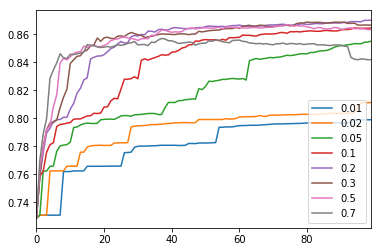

In [30]:
results_eta = [result['validation_0']['auc'] for result in model_results]
results_eta = pd.DataFrame(results_eta).transpose()
results_eta.columns = etas
results_eta.plot.line()

If we limit ourselves to 100 rounds of boosting, we find that the optimal eta must be greater than 0.05 and less than 0.7. I'm almost certain this will change depending on the number of boosting rounds, but at this point in time I don't think it will be worth exploring the interplay thoroughly due to constraints on my hardware. Zooming in for a better look.

In [34]:
print(results_eta.columns,

Float64Index([0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7], dtype='float64') <class 'list'>


(0.0, 99.0, 0.84, 0.89)

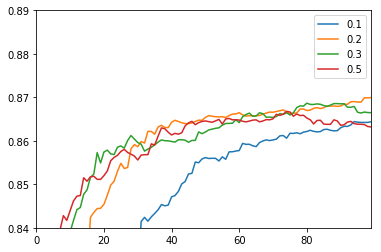

In [39]:
plot = results_eta[[0.1,0.2,0.3,0.5]].plot.line()
plot.axis(ymin=0.84, ymax=0.89)

Upon closer inspection, a value of 0.2 seems to be optimal. Now we repeat the process but for n_estimators, the number of boosting rounds that xgb will implement. This could take a while to compute...

In [ ]:
### I will set n_estimators to 500 and running once as testing for 100, 200, 300, 500 would contain
# the same results nested in each other
eval_set = [(X_val,y_val)]
 

model = xgb.XGBClassifier(
learning_rate = 0.2,
n_estimators = 500,
objective = 'binary:logistic')

model.fit(X_train, y_train, 
      eval_metric = "auc", 
      eval_set= eval_set)

[0]	validation_0-auc:0.728976
[1]	validation_0-auc:0.758629
[2]	validation_0-auc:0.775613
[3]	validation_0-auc:0.789627
[4]	validation_0-auc:0.792915
[5]	validation_0-auc:0.79774
[6]	validation_0-auc:0.799051
[7]	validation_0-auc:0.799201
[8]	validation_0-auc:0.800766
[9]	validation_0-auc:0.800663
[10]	validation_0-auc:0.806523
[11]	validation_0-auc:0.810603
[12]	validation_0-auc:0.817915
[13]	validation_0-auc:0.821419
[14]	validation_0-auc:0.827384
[15]	validation_0-auc:0.828863
[16]	validation_0-auc:0.842391
[17]	validation_0-auc:0.843526
[18]	validation_0-auc:0.844424
[19]	validation_0-auc:0.844482
[20]	validation_0-auc:0.8454
[21]	validation_0-auc:0.847509
[22]	validation_0-auc:0.849813
[23]	validation_0-auc:0.850711


So it appears that after 300 rounds of boosting, the validation AUC tapers off and starts to decrease. Mind you this isn't an exact science so this decline in the AUC score could be due to patterns in the validation set not found in the test set, but this is our best guess.

In [6]:
depths = [1,2,5,10,20,50]

model_results = []

for depth in depths:
    
    eval_set = [(X_val,y_val)]
    
    model = xgb.XGBClassifier(
    learning_rate = 0.2,
    n_estimators = 300,
    max_depth = depth,
    objective = 'binary:logistic')
    
    model.fit(X_train, y_train, 
          eval_metric = "auc", 
          eval_set= eval_set,)
    
    model_results.append(model.evals_result())


[0]	validation_0-auc:0.568424
[1]	validation_0-auc:0.570365
[2]	validation_0-auc:0.608577
[3]	validation_0-auc:0.616836
[4]	validation_0-auc:0.630341
[5]	validation_0-auc:0.637103
[6]	validation_0-auc:0.637656
[7]	validation_0-auc:0.636907
[8]	validation_0-auc:0.637472
[9]	validation_0-auc:0.658537
[10]	validation_0-auc:0.662273
[11]	validation_0-auc:0.662165
[12]	validation_0-auc:0.726678
[13]	validation_0-auc:0.776227
[14]	validation_0-auc:0.777093
[15]	validation_0-auc:0.777456
[16]	validation_0-auc:0.789202
[17]	validation_0-auc:0.787342
[18]	validation_0-auc:0.792128
[19]	validation_0-auc:0.795084
[20]	validation_0-auc:0.801293
[21]	validation_0-auc:0.800448
[22]	validation_0-auc:0.798351
[23]	validation_0-auc:0.800329
[24]	validation_0-auc:0.793419
[25]	validation_0-auc:0.794115
[26]	validation_0-auc:0.794049
[27]	validation_0-auc:0.80361
[28]	validation_0-auc:0.805727
[29]	validation_0-auc:0.820968
[30]	validation_0-auc:0.812092
[31]	validation_0-auc:0.813618
[32]	validation_0-a

[261]	validation_0-auc:0.853446
[262]	validation_0-auc:0.853522
[263]	validation_0-auc:0.853671
[264]	validation_0-auc:0.853671
[265]	validation_0-auc:0.853606
[266]	validation_0-auc:0.853334
[267]	validation_0-auc:0.853854
[268]	validation_0-auc:0.853513
[269]	validation_0-auc:0.853584
[270]	validation_0-auc:0.853493
[271]	validation_0-auc:0.853493
[272]	validation_0-auc:0.853998
[273]	validation_0-auc:0.854102
[274]	validation_0-auc:0.854338
[275]	validation_0-auc:0.85434
[276]	validation_0-auc:0.854395
[277]	validation_0-auc:0.854346
[278]	validation_0-auc:0.854407
[279]	validation_0-auc:0.85438
[280]	validation_0-auc:0.85432
[281]	validation_0-auc:0.854528
[282]	validation_0-auc:0.853842
[283]	validation_0-auc:0.853878
[284]	validation_0-auc:0.853905
[285]	validation_0-auc:0.853941
[286]	validation_0-auc:0.853948
[287]	validation_0-auc:0.853983
[288]	validation_0-auc:0.853997
[289]	validation_0-auc:0.854432
[290]	validation_0-auc:0.854023
[291]	validation_0-auc:0.853977
[292]	valid

[222]	validation_0-auc:0.870692
[223]	validation_0-auc:0.870646
[224]	validation_0-auc:0.87065
[225]	validation_0-auc:0.870506
[226]	validation_0-auc:0.870272
[227]	validation_0-auc:0.870253
[228]	validation_0-auc:0.870168
[229]	validation_0-auc:0.870158
[230]	validation_0-auc:0.87009
[231]	validation_0-auc:0.870139
[232]	validation_0-auc:0.870135
[233]	validation_0-auc:0.870051
[234]	validation_0-auc:0.870252
[235]	validation_0-auc:0.870214
[236]	validation_0-auc:0.870195
[237]	validation_0-auc:0.870455
[238]	validation_0-auc:0.87048
[239]	validation_0-auc:0.870448
[240]	validation_0-auc:0.870512
[241]	validation_0-auc:0.870537
[242]	validation_0-auc:0.870637
[243]	validation_0-auc:0.870655
[244]	validation_0-auc:0.870639
[245]	validation_0-auc:0.871014
[246]	validation_0-auc:0.870996
[247]	validation_0-auc:0.870982
[248]	validation_0-auc:0.870981
[249]	validation_0-auc:0.871167
[250]	validation_0-auc:0.87106
[251]	validation_0-auc:0.87109
[252]	validation_0-auc:0.87065
[253]	validati

[182]	validation_0-auc:0.873672
[183]	validation_0-auc:0.873536
[184]	validation_0-auc:0.873182
[185]	validation_0-auc:0.873129
[186]	validation_0-auc:0.87276
[187]	validation_0-auc:0.872621
[188]	validation_0-auc:0.87218
[189]	validation_0-auc:0.872447
[190]	validation_0-auc:0.872182
[191]	validation_0-auc:0.872221
[192]	validation_0-auc:0.87219
[193]	validation_0-auc:0.872197
[194]	validation_0-auc:0.872372
[195]	validation_0-auc:0.872418
[196]	validation_0-auc:0.872034
[197]	validation_0-auc:0.872096
[198]	validation_0-auc:0.871041
[199]	validation_0-auc:0.871328
[200]	validation_0-auc:0.871478
[201]	validation_0-auc:0.87154
[202]	validation_0-auc:0.87144
[203]	validation_0-auc:0.871532
[204]	validation_0-auc:0.871271
[205]	validation_0-auc:0.871215
[206]	validation_0-auc:0.871214
[207]	validation_0-auc:0.870888
[208]	validation_0-auc:0.870508
[209]	validation_0-auc:0.870485
[210]	validation_0-auc:0.87041
[211]	validation_0-auc:0.870432
[212]	validation_0-auc:0.870379
[213]	validati

[143]	validation_0-auc:0.884286
[144]	validation_0-auc:0.884192
[145]	validation_0-auc:0.884133
[146]	validation_0-auc:0.884472
[147]	validation_0-auc:0.88452
[148]	validation_0-auc:0.884523
[149]	validation_0-auc:0.884746
[150]	validation_0-auc:0.884703
[151]	validation_0-auc:0.883999
[152]	validation_0-auc:0.884017
[153]	validation_0-auc:0.883907
[154]	validation_0-auc:0.883611
[155]	validation_0-auc:0.883623
[156]	validation_0-auc:0.884021
[157]	validation_0-auc:0.884073
[158]	validation_0-auc:0.883937
[159]	validation_0-auc:0.884101
[160]	validation_0-auc:0.884405
[161]	validation_0-auc:0.884299
[162]	validation_0-auc:0.883585
[163]	validation_0-auc:0.883705
[164]	validation_0-auc:0.883446
[165]	validation_0-auc:0.88342
[166]	validation_0-auc:0.883521
[167]	validation_0-auc:0.88375
[168]	validation_0-auc:0.883798
[169]	validation_0-auc:0.883582
[170]	validation_0-auc:0.883727
[171]	validation_0-auc:0.883561
[172]	validation_0-auc:0.883604
[173]	validation_0-auc:0.883776
[174]	valid

[103]	validation_0-auc:0.887247
[104]	validation_0-auc:0.887436
[105]	validation_0-auc:0.887454
[106]	validation_0-auc:0.887768
[107]	validation_0-auc:0.887841
[108]	validation_0-auc:0.88785
[109]	validation_0-auc:0.887788
[110]	validation_0-auc:0.887601
[111]	validation_0-auc:0.887591
[112]	validation_0-auc:0.88782
[113]	validation_0-auc:0.887766
[114]	validation_0-auc:0.887758
[115]	validation_0-auc:0.887848
[116]	validation_0-auc:0.887986
[117]	validation_0-auc:0.888026
[118]	validation_0-auc:0.888034
[119]	validation_0-auc:0.888059
[120]	validation_0-auc:0.887806
[121]	validation_0-auc:0.887579
[122]	validation_0-auc:0.887601
[123]	validation_0-auc:0.887587
[124]	validation_0-auc:0.887675
[125]	validation_0-auc:0.88784
[126]	validation_0-auc:0.887976
[127]	validation_0-auc:0.887722
[128]	validation_0-auc:0.888046
[129]	validation_0-auc:0.888147
[130]	validation_0-auc:0.888533
[131]	validation_0-auc:0.888618
[132]	validation_0-auc:0.88851
[133]	validation_0-auc:0.888594
[134]	valida

[63]	validation_0-auc:0.885812
[64]	validation_0-auc:0.885924
[65]	validation_0-auc:0.886051
[66]	validation_0-auc:0.886283
[67]	validation_0-auc:0.886084
[68]	validation_0-auc:0.886202
[69]	validation_0-auc:0.886213
[70]	validation_0-auc:0.886145
[71]	validation_0-auc:0.886187
[72]	validation_0-auc:0.886102
[73]	validation_0-auc:0.886181
[74]	validation_0-auc:0.886085
[75]	validation_0-auc:0.886397
[76]	validation_0-auc:0.885774
[77]	validation_0-auc:0.885945
[78]	validation_0-auc:0.886029
[79]	validation_0-auc:0.886317
[80]	validation_0-auc:0.886389
[81]	validation_0-auc:0.886333
[82]	validation_0-auc:0.886369
[83]	validation_0-auc:0.886467
[84]	validation_0-auc:0.886649
[85]	validation_0-auc:0.886712
[86]	validation_0-auc:0.886591
[87]	validation_0-auc:0.88696
[88]	validation_0-auc:0.887051
[89]	validation_0-auc:0.887026
[90]	validation_0-auc:0.887127
[91]	validation_0-auc:0.886922
[92]	validation_0-auc:0.886961
[93]	validation_0-auc:0.887101
[94]	validation_0-auc:0.88699
[95]	valid

In [13]:
results_depths = [result['validation_0']['auc'] for result in model_results]
results_depths = pd.DataFrame(results_depths).transpose()
results_depths.columns = depths
print(results_depths.max())
print(results_depths.mean())

1     0.854528
2     0.871167
5     0.881989
10    0.892540
20    0.889057
50    0.887596
dtype: float64
1     0.835458
2     0.860562
5     0.871281
10    0.882317
20    0.882774
50    0.882113
dtype: float64


Best AUC score for each setting for max_depth is reported above. A max depth of 10 gives the highest possible AUC score with depth = 20 pretty close behind. However on average, it seems that a depth of 20 seems to perform marginally better. Let's set depth to 20 and tune gamma, the parameter which determines how much the loss must reduce by before further partitioning a node. A higher value means that the algorithm is more conservative and is less likely to overfitl.

In [6]:
gammas = [0.01,0.02,0.05,0.1,0.2,0.3]

model_results = []

for gamma in gammas:
    
    eval_set = [(X_val,y_val)]
    
    model = xgb.XGBClassifier(
    learning_rate = 0.2,
    n_estimators = 300,
    max_depth = 20,
    gamma = gamma,
    objective = 'binary:logistic')
    
    model.fit(X_train, y_train, 
          eval_metric = "auc", 
          eval_set= eval_set,)
    
    model_results.append(model.evals_result())


[0]	validation_0-auc:0.796884
[1]	validation_0-auc:0.803132
[2]	validation_0-auc:0.815908
[3]	validation_0-auc:0.827564
[4]	validation_0-auc:0.831102
[5]	validation_0-auc:0.833778
[6]	validation_0-auc:0.834141
[7]	validation_0-auc:0.836554
[8]	validation_0-auc:0.839702
[9]	validation_0-auc:0.839387
[10]	validation_0-auc:0.847366
[11]	validation_0-auc:0.850964
[12]	validation_0-auc:0.846243
[13]	validation_0-auc:0.850683
[14]	validation_0-auc:0.855358
[15]	validation_0-auc:0.857725
[16]	validation_0-auc:0.860028
[17]	validation_0-auc:0.861797
[18]	validation_0-auc:0.861829
[19]	validation_0-auc:0.863094
[20]	validation_0-auc:0.863589
[21]	validation_0-auc:0.863742
[22]	validation_0-auc:0.865788
[23]	validation_0-auc:0.86826
[24]	validation_0-auc:0.869589
[25]	validation_0-auc:0.871043
[26]	validation_0-auc:0.872707
[27]	validation_0-auc:0.875538
[28]	validation_0-auc:0.876433
[29]	validation_0-auc:0.878324
[30]	validation_0-auc:0.878182
[31]	validation_0-auc:0.879341
[32]	validation_0-a

[261]	validation_0-auc:0.885339
[262]	validation_0-auc:0.885222
[263]	validation_0-auc:0.88532
[264]	validation_0-auc:0.88534
[265]	validation_0-auc:0.885115
[266]	validation_0-auc:0.885098
[267]	validation_0-auc:0.885056
[268]	validation_0-auc:0.885035
[269]	validation_0-auc:0.884923
[270]	validation_0-auc:0.884823
[271]	validation_0-auc:0.88488
[272]	validation_0-auc:0.884884
[273]	validation_0-auc:0.884859
[274]	validation_0-auc:0.885
[275]	validation_0-auc:0.884977
[276]	validation_0-auc:0.885062
[277]	validation_0-auc:0.885072
[278]	validation_0-auc:0.885156
[279]	validation_0-auc:0.885167
[280]	validation_0-auc:0.885322
[281]	validation_0-auc:0.885386
[282]	validation_0-auc:0.885371
[283]	validation_0-auc:0.885475
[284]	validation_0-auc:0.885524
[285]	validation_0-auc:0.885538
[286]	validation_0-auc:0.885587
[287]	validation_0-auc:0.885593
[288]	validation_0-auc:0.885498
[289]	validation_0-auc:0.885528
[290]	validation_0-auc:0.885534
[291]	validation_0-auc:0.885589
[292]	validati

[222]	validation_0-auc:0.88922
[223]	validation_0-auc:0.889194
[224]	validation_0-auc:0.889311
[225]	validation_0-auc:0.889209
[226]	validation_0-auc:0.889123
[227]	validation_0-auc:0.889017
[228]	validation_0-auc:0.888877
[229]	validation_0-auc:0.888826
[230]	validation_0-auc:0.888831
[231]	validation_0-auc:0.888882
[232]	validation_0-auc:0.888938
[233]	validation_0-auc:0.888937
[234]	validation_0-auc:0.888949
[235]	validation_0-auc:0.889008
[236]	validation_0-auc:0.888974
[237]	validation_0-auc:0.888952
[238]	validation_0-auc:0.888988
[239]	validation_0-auc:0.888991
[240]	validation_0-auc:0.888876
[241]	validation_0-auc:0.888826
[242]	validation_0-auc:0.888788
[243]	validation_0-auc:0.889051
[244]	validation_0-auc:0.889148
[245]	validation_0-auc:0.889135
[246]	validation_0-auc:0.889158
[247]	validation_0-auc:0.889145
[248]	validation_0-auc:0.889155
[249]	validation_0-auc:0.889093
[250]	validation_0-auc:0.889015
[251]	validation_0-auc:0.888964
[252]	validation_0-auc:0.888901
[253]	val

[183]	validation_0-auc:0.88444
[184]	validation_0-auc:0.884439
[185]	validation_0-auc:0.884645
[186]	validation_0-auc:0.88465
[187]	validation_0-auc:0.884591
[188]	validation_0-auc:0.884716
[189]	validation_0-auc:0.884775
[190]	validation_0-auc:0.884682
[191]	validation_0-auc:0.884703
[192]	validation_0-auc:0.884924
[193]	validation_0-auc:0.884817
[194]	validation_0-auc:0.884842
[195]	validation_0-auc:0.884925
[196]	validation_0-auc:0.884978
[197]	validation_0-auc:0.884957
[198]	validation_0-auc:0.884938
[199]	validation_0-auc:0.884988
[200]	validation_0-auc:0.884954
[201]	validation_0-auc:0.884917
[202]	validation_0-auc:0.885028
[203]	validation_0-auc:0.885044
[204]	validation_0-auc:0.884947
[205]	validation_0-auc:0.884914
[206]	validation_0-auc:0.88498
[207]	validation_0-auc:0.88504
[208]	validation_0-auc:0.88505
[209]	validation_0-auc:0.885055
[210]	validation_0-auc:0.88508
[211]	validation_0-auc:0.884948
[212]	validation_0-auc:0.88506
[213]	validation_0-auc:0.88492
[214]	validation

[144]	validation_0-auc:0.882606
[145]	validation_0-auc:0.882626
[146]	validation_0-auc:0.88279
[147]	validation_0-auc:0.882899
[148]	validation_0-auc:0.882927
[149]	validation_0-auc:0.882848
[150]	validation_0-auc:0.882862
[151]	validation_0-auc:0.882878
[152]	validation_0-auc:0.8829
[153]	validation_0-auc:0.88287
[154]	validation_0-auc:0.883185
[155]	validation_0-auc:0.883221
[156]	validation_0-auc:0.883275
[157]	validation_0-auc:0.88329
[158]	validation_0-auc:0.883302
[159]	validation_0-auc:0.883183
[160]	validation_0-auc:0.883201
[161]	validation_0-auc:0.883209
[162]	validation_0-auc:0.88326
[163]	validation_0-auc:0.883128
[164]	validation_0-auc:0.883293
[165]	validation_0-auc:0.883283
[166]	validation_0-auc:0.883139
[167]	validation_0-auc:0.883162
[168]	validation_0-auc:0.883201
[169]	validation_0-auc:0.883236
[170]	validation_0-auc:0.88323
[171]	validation_0-auc:0.883241
[172]	validation_0-auc:0.88337
[173]	validation_0-auc:0.883414
[174]	validation_0-auc:0.883487
[175]	validation

[105]	validation_0-auc:0.884372
[106]	validation_0-auc:0.884432
[107]	validation_0-auc:0.884216
[108]	validation_0-auc:0.884206
[109]	validation_0-auc:0.884139
[110]	validation_0-auc:0.884124
[111]	validation_0-auc:0.884001
[112]	validation_0-auc:0.884149
[113]	validation_0-auc:0.884166
[114]	validation_0-auc:0.884188
[115]	validation_0-auc:0.884033
[116]	validation_0-auc:0.88399
[117]	validation_0-auc:0.883896
[118]	validation_0-auc:0.883661
[119]	validation_0-auc:0.883628
[120]	validation_0-auc:0.883692
[121]	validation_0-auc:0.883701
[122]	validation_0-auc:0.883681
[123]	validation_0-auc:0.883548
[124]	validation_0-auc:0.883869
[125]	validation_0-auc:0.883448
[126]	validation_0-auc:0.883325
[127]	validation_0-auc:0.88338
[128]	validation_0-auc:0.883359
[129]	validation_0-auc:0.883641
[130]	validation_0-auc:0.883563
[131]	validation_0-auc:0.88354
[132]	validation_0-auc:0.883546
[133]	validation_0-auc:0.883572
[134]	validation_0-auc:0.88343
[135]	validation_0-auc:0.883384
[136]	valida

[64]	validation_0-auc:0.884651
[65]	validation_0-auc:0.883915
[66]	validation_0-auc:0.884052
[67]	validation_0-auc:0.884095
[68]	validation_0-auc:0.884139
[69]	validation_0-auc:0.88408
[70]	validation_0-auc:0.883969
[71]	validation_0-auc:0.884022
[72]	validation_0-auc:0.884054
[73]	validation_0-auc:0.883685
[74]	validation_0-auc:0.88348
[75]	validation_0-auc:0.883499
[76]	validation_0-auc:0.883638
[77]	validation_0-auc:0.88376
[78]	validation_0-auc:0.883838
[79]	validation_0-auc:0.883978
[80]	validation_0-auc:0.883862
[81]	validation_0-auc:0.883724
[82]	validation_0-auc:0.883818
[83]	validation_0-auc:0.883679
[84]	validation_0-auc:0.883897
[85]	validation_0-auc:0.883717
[86]	validation_0-auc:0.883795
[87]	validation_0-auc:0.883927
[88]	validation_0-auc:0.883992
[89]	validation_0-auc:0.88377
[90]	validation_0-auc:0.88382
[91]	validation_0-auc:0.883645
[92]	validation_0-auc:0.883864
[93]	validation_0-auc:0.883626
[94]	validation_0-auc:0.883962
[95]	validation_0-auc:0.88412
[96]	validatio

In [9]:
results_gammas = [result['validation_0']['auc'] for result in model_results]
results_gammas = pd.DataFrame(results_gammas).transpose()
results_gammas.columns = gammas
print(results_gammas.max())
print(results_gammas.mean())

0.01    0.887901
0.02    0.889775
0.05    0.885080
0.10    0.884227
0.20    0.884457
0.30    0.884831
dtype: float64
0.01    0.882490
0.02    0.883760
0.05    0.879560
0.10    0.878677
0.20    0.879949
0.30    0.880135
dtype: float64


Values of gamma which are too large leads to the model underfitting slightly. The decicions trees stop prematurely in making splits leading to a loss in predictive power. However a small value of gamma ~0.02 gives us a slight uptick in performance, let's stick with that and regularise colsample_bytree.

In [7]:
tree_samples = [0.9,0.8,0.7,0.6,0.5]

model_results = []

for tree_sample in tree_samples:
    
    eval_set = [(X_val,y_val)]
    
    model = xgb.XGBClassifier(
    learning_rate = 0.2,
    n_estimators = 300,
    max_depth = 20,
    gamma = 0.02,
    colsample_bytree = tree_sample,
    objective = 'binary:logistic')
    
    model.fit(X_train, y_train, 
          eval_metric = "auc", 
          eval_set= eval_set,)
    
    model_results.append(model.evals_result())


[0]	validation_0-auc:0.800762
[1]	validation_0-auc:0.810369
[2]	validation_0-auc:0.827067
[3]	validation_0-auc:0.838785
[4]	validation_0-auc:0.841446
[5]	validation_0-auc:0.846621
[6]	validation_0-auc:0.847019
[7]	validation_0-auc:0.848578
[8]	validation_0-auc:0.85035
[9]	validation_0-auc:0.844601
[10]	validation_0-auc:0.841688
[11]	validation_0-auc:0.84615
[12]	validation_0-auc:0.848567
[13]	validation_0-auc:0.848235
[14]	validation_0-auc:0.848896
[15]	validation_0-auc:0.853545
[16]	validation_0-auc:0.854421
[17]	validation_0-auc:0.855749
[18]	validation_0-auc:0.856537
[19]	validation_0-auc:0.85847
[20]	validation_0-auc:0.861221
[21]	validation_0-auc:0.862045
[22]	validation_0-auc:0.864525
[23]	validation_0-auc:0.866186
[24]	validation_0-auc:0.86749
[25]	validation_0-auc:0.869526
[26]	validation_0-auc:0.869695
[27]	validation_0-auc:0.870632
[28]	validation_0-auc:0.873172
[29]	validation_0-auc:0.873933
[30]	validation_0-auc:0.874556
[31]	validation_0-auc:0.875378
[32]	validation_0-auc:

[261]	validation_0-auc:0.883527
[262]	validation_0-auc:0.883595
[263]	validation_0-auc:0.883592
[264]	validation_0-auc:0.883604
[265]	validation_0-auc:0.883453
[266]	validation_0-auc:0.883392
[267]	validation_0-auc:0.883603
[268]	validation_0-auc:0.883656
[269]	validation_0-auc:0.883622
[270]	validation_0-auc:0.883546
[271]	validation_0-auc:0.883429
[272]	validation_0-auc:0.883502
[273]	validation_0-auc:0.88346
[274]	validation_0-auc:0.883454
[275]	validation_0-auc:0.883415
[276]	validation_0-auc:0.883435
[277]	validation_0-auc:0.883441
[278]	validation_0-auc:0.88345
[279]	validation_0-auc:0.883501
[280]	validation_0-auc:0.88344
[281]	validation_0-auc:0.883313
[282]	validation_0-auc:0.883317
[283]	validation_0-auc:0.88335
[284]	validation_0-auc:0.883422
[285]	validation_0-auc:0.883432
[286]	validation_0-auc:0.8835
[287]	validation_0-auc:0.883547
[288]	validation_0-auc:0.883525
[289]	validation_0-auc:0.883562
[290]	validation_0-auc:0.883574
[291]	validation_0-auc:0.883457
[292]	validati

[222]	validation_0-auc:0.891774
[223]	validation_0-auc:0.891555
[224]	validation_0-auc:0.891548
[225]	validation_0-auc:0.891619
[226]	validation_0-auc:0.891681
[227]	validation_0-auc:0.891575
[228]	validation_0-auc:0.891544
[229]	validation_0-auc:0.891397
[230]	validation_0-auc:0.891385
[231]	validation_0-auc:0.891281
[232]	validation_0-auc:0.89121
[233]	validation_0-auc:0.891247
[234]	validation_0-auc:0.891179
[235]	validation_0-auc:0.891135
[236]	validation_0-auc:0.890984
[237]	validation_0-auc:0.890943
[238]	validation_0-auc:0.890828
[239]	validation_0-auc:0.890923
[240]	validation_0-auc:0.890897
[241]	validation_0-auc:0.891053
[242]	validation_0-auc:0.891047
[243]	validation_0-auc:0.890968
[244]	validation_0-auc:0.890944
[245]	validation_0-auc:0.890794
[246]	validation_0-auc:0.890837
[247]	validation_0-auc:0.89071
[248]	validation_0-auc:0.890688
[249]	validation_0-auc:0.890753
[250]	validation_0-auc:0.890627
[251]	validation_0-auc:0.890654
[252]	validation_0-auc:0.890623
[253]	vali

[183]	validation_0-auc:0.889671
[184]	validation_0-auc:0.889658
[185]	validation_0-auc:0.889484
[186]	validation_0-auc:0.889475
[187]	validation_0-auc:0.889268
[188]	validation_0-auc:0.889398
[189]	validation_0-auc:0.889501
[190]	validation_0-auc:0.889459
[191]	validation_0-auc:0.889466
[192]	validation_0-auc:0.889528
[193]	validation_0-auc:0.889425
[194]	validation_0-auc:0.889468
[195]	validation_0-auc:0.889468
[196]	validation_0-auc:0.889658
[197]	validation_0-auc:0.88966
[198]	validation_0-auc:0.889722
[199]	validation_0-auc:0.889827
[200]	validation_0-auc:0.889887
[201]	validation_0-auc:0.88997
[202]	validation_0-auc:0.890031
[203]	validation_0-auc:0.890008
[204]	validation_0-auc:0.890143
[205]	validation_0-auc:0.890113
[206]	validation_0-auc:0.890095
[207]	validation_0-auc:0.889942
[208]	validation_0-auc:0.88993
[209]	validation_0-auc:0.890087
[210]	validation_0-auc:0.889958
[211]	validation_0-auc:0.889888
[212]	validation_0-auc:0.889937
[213]	validation_0-auc:0.890005
[214]	valid

[144]	validation_0-auc:0.88987
[145]	validation_0-auc:0.889855
[146]	validation_0-auc:0.88974
[147]	validation_0-auc:0.889818
[148]	validation_0-auc:0.889699
[149]	validation_0-auc:0.889549
[150]	validation_0-auc:0.889634
[151]	validation_0-auc:0.889617
[152]	validation_0-auc:0.889491
[153]	validation_0-auc:0.889621
[154]	validation_0-auc:0.889715
[155]	validation_0-auc:0.889612
[156]	validation_0-auc:0.889563
[157]	validation_0-auc:0.889636
[158]	validation_0-auc:0.88953
[159]	validation_0-auc:0.889722
[160]	validation_0-auc:0.889565
[161]	validation_0-auc:0.889599
[162]	validation_0-auc:0.889673
[163]	validation_0-auc:0.889661
[164]	validation_0-auc:0.889779
[165]	validation_0-auc:0.889879
[166]	validation_0-auc:0.889835
[167]	validation_0-auc:0.889892
[168]	validation_0-auc:0.8898
[169]	validation_0-auc:0.88984
[170]	validation_0-auc:0.889754
[171]	validation_0-auc:0.889834
[172]	validation_0-auc:0.889758
[173]	validation_0-auc:0.889771
[174]	validation_0-auc:0.88976
[175]	validatio

[105]	validation_0-auc:0.888655
[106]	validation_0-auc:0.888684
[107]	validation_0-auc:0.888648
[108]	validation_0-auc:0.888505
[109]	validation_0-auc:0.888442
[110]	validation_0-auc:0.888307
[111]	validation_0-auc:0.888385
[112]	validation_0-auc:0.888444
[113]	validation_0-auc:0.888102
[114]	validation_0-auc:0.887805
[115]	validation_0-auc:0.887764
[116]	validation_0-auc:0.887676
[117]	validation_0-auc:0.887515
[118]	validation_0-auc:0.887327
[119]	validation_0-auc:0.88731
[120]	validation_0-auc:0.887187
[121]	validation_0-auc:0.88725
[122]	validation_0-auc:0.887236
[123]	validation_0-auc:0.887354
[124]	validation_0-auc:0.887334
[125]	validation_0-auc:0.887434
[126]	validation_0-auc:0.887471
[127]	validation_0-auc:0.887442
[128]	validation_0-auc:0.88746
[129]	validation_0-auc:0.887434
[130]	validation_0-auc:0.887361
[131]	validation_0-auc:0.88747
[132]	validation_0-auc:0.887364
[133]	validation_0-auc:0.8872
[134]	validation_0-auc:0.887083
[135]	validation_0-auc:0.887259
[136]	validati

In [8]:
results_trees = [result['validation_0']['auc'] for result in model_results]
results_trees = pd.DataFrame(results_trees).transpose()
results_trees.columns = tree_samples
print(results_trees.max())
print(results_trees.mean())

0.9    0.884781
0.8    0.893362
0.7    0.890143
0.6    0.890578
0.5    0.888684
dtype: float64
0.9    0.880222
0.8    0.887391
0.7    0.885328
0.6    0.886034
0.5    0.884469
dtype: float64


Not sure why playing around with the column improves performance, can't argue with the evidence. Using a sampling proportion of 0.8-0.6 seems to net significant improvements. In fact for 0.8, the highest score allows us to break into the 0.893 realm which is quite pleasing to see.

The next stage will be to tune the number of early stopping rounds. For a more accurate result we will need a second outer validation set. As far as I'm aware, it is not entirely correct to use the same validation set to tune the hyperparameters as is used to choose early stopping. This is because the early stopping in a sense 'sees' the first validation set so optimal values chosen by it may be biased to idiosyncratic features of that set. Using another validation set to check for this will assist in generalisation (hopefully).

In [ ]:
early_stopping_rounds = [10, 20, 30, 50, 100]

model_results = []
val_2_scores = []

for early_stop in early_stopping_rounds:
    
    eval_set = [(X_val,y_val)]
    
    model = xgb.XGBClassifier(
    learning_rate = 0.2,
    n_estimators = 300,
    max_depth = 20,
    gamma = 0.02,
    colsample_bytree = 0.8,
    objective = 'binary:logistic')
    
    model.fit(
        X_train, y_train, 
        eval_metric = "auc", 
        eval_set= eval_set,
        early_stopping_rounds = early_stop
           )
    
    preds = model.predict_proba(X_val_2)
    val_2_score = roc_auc_score(y_val_2, preds[:,1])
    val_2_scores.append(val_2_score)
    
    print(val_2_score)
    
    model_results.append(model.evals_result())


[0]	validation_0-auc:0.78466
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.801972
[2]	validation_0-auc:0.827043
[3]	validation_0-auc:0.834126
[4]	validation_0-auc:0.845742
[5]	validation_0-auc:0.853517
[6]	validation_0-auc:0.855688
[7]	validation_0-auc:0.840548
[8]	validation_0-auc:0.838475
[9]	validation_0-auc:0.839251
[10]	validation_0-auc:0.839531
[11]	validation_0-auc:0.847766
[12]	validation_0-auc:0.851542
[13]	validation_0-auc:0.856422
[14]	validation_0-auc:0.8572
[15]	validation_0-auc:0.859089
[16]	validation_0-auc:0.859074
[17]	validation_0-auc:0.860918
[18]	validation_0-auc:0.865279
[19]	validation_0-auc:0.8671
[20]	validation_0-auc:0.86874
[21]	validation_0-auc:0.870198
[22]	validation_0-auc:0.872211
[23]	validation_0-auc:0.874323
[24]	validation_0-auc:0.874928
[25]	validation_0-auc:0.876235
[26]	validation_0-auc:0.87739
[27]	validation_0-auc:0.878177
[28]	validation_0-auc:0.878496
[29]	validation_0-auc:0.879338
[30]	validation_0-auc:0

[131]	validation_0-auc:0.892834
[132]	validation_0-auc:0.892616
[133]	validation_0-auc:0.89254
[134]	validation_0-auc:0.892605
[135]	validation_0-auc:0.892642
[136]	validation_0-auc:0.892644
[137]	validation_0-auc:0.892589
[138]	validation_0-auc:0.892726
[139]	validation_0-auc:0.89262
[140]	validation_0-auc:0.892476
[141]	validation_0-auc:0.892554
[142]	validation_0-auc:0.892535
[143]	validation_0-auc:0.892537
[144]	validation_0-auc:0.892664
[145]	validation_0-auc:0.892704
[146]	validation_0-auc:0.892786
[147]	validation_0-auc:0.892919
[148]	validation_0-auc:0.893045
[149]	validation_0-auc:0.893155
[150]	validation_0-auc:0.893018
[151]	validation_0-auc:0.893317
[152]	validation_0-auc:0.893243
[153]	validation_0-auc:0.893277
[154]	validation_0-auc:0.893362
[155]	validation_0-auc:0.893244
[156]	validation_0-auc:0.89308
[157]	validation_0-auc:0.893157
[158]	validation_0-auc:0.893127
[159]	validation_0-auc:0.893235
[160]	validation_0-auc:0.893273
[161]	validation_0-auc:0.893286
[162]	valid

[24]	validation_0-auc:0.874928
[25]	validation_0-auc:0.876235
[26]	validation_0-auc:0.87739
[27]	validation_0-auc:0.878177
[28]	validation_0-auc:0.878496
[29]	validation_0-auc:0.879338
[30]	validation_0-auc:0.879595
[31]	validation_0-auc:0.881123
[32]	validation_0-auc:0.881949
[33]	validation_0-auc:0.882369
[34]	validation_0-auc:0.882727
[35]	validation_0-auc:0.882977
[36]	validation_0-auc:0.884006
[37]	validation_0-auc:0.884783
[38]	validation_0-auc:0.885107
[39]	validation_0-auc:0.885526
[40]	validation_0-auc:0.885977
[41]	validation_0-auc:0.885628
[42]	validation_0-auc:0.886048
[43]	validation_0-auc:0.886628
[44]	validation_0-auc:0.886875
[45]	validation_0-auc:0.887507
[46]	validation_0-auc:0.887762
[47]	validation_0-auc:0.888618
[48]	validation_0-auc:0.88896
[49]	validation_0-auc:0.888442
[50]	validation_0-auc:0.888255
[51]	validation_0-auc:0.888664
[52]	validation_0-auc:0.88901
[53]	validation_0-auc:0.889133
[54]	validation_0-auc:0.889191
[55]	validation_0-auc:0.889538
[56]	valida

30 rounds for early stopping seems to be sufficient in ensuring that the xgboost algorithm reaches a high enough validation score. Though I'm a bit worried by the disparity between the auc score on the first validation set and the auc score on the second validation set. This may be a sign of overfitting or may be due to random chance.

Let's fit this model specification and submit to the leaderboard. This should lead to an increase in our public AUC.

In [5]:
X_train, X_val, y_train, y_val = train_test_split(train, y, test_size = 0.2, shuffle=False)
eval_set = [(X_val, y_val)]

In [6]:

model = xgb.XGBClassifier(
    learning_rate = 0.2,
    n_estimators = 300,
    max_depth = 20,
    gamma = 0.02,
    colsample_bytree = 0.8,
    objective = 'binary:logistic'
)

model.fit(
    X_train, y_train, 
    eval_metric = "auc", 
    eval_set= eval_set,
    early_stopping_rounds = 30
       )



[0]	validation_0-auc:0.808201
Will train until validation_0-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.829004
[2]	validation_0-auc:0.834457
[3]	validation_0-auc:0.839397
[4]	validation_0-auc:0.843481
[5]	validation_0-auc:0.845723
[6]	validation_0-auc:0.849973
[7]	validation_0-auc:0.848348
[8]	validation_0-auc:0.85481
[9]	validation_0-auc:0.859382
[10]	validation_0-auc:0.862738
[11]	validation_0-auc:0.865591
[12]	validation_0-auc:0.867944
[13]	validation_0-auc:0.872678
[14]	validation_0-auc:0.876047
[15]	validation_0-auc:0.877656
[16]	validation_0-auc:0.878374
[17]	validation_0-auc:0.881602
[18]	validation_0-auc:0.884596
[19]	validation_0-auc:0.884995
[20]	validation_0-auc:0.88628
[21]	validation_0-auc:0.887921
[22]	validation_0-auc:0.889819
[23]	validation_0-auc:0.891595
[24]	validation_0-auc:0.892218
[25]	validation_0-auc:0.892238
[26]	validation_0-auc:0.89357
[27]	validation_0-auc:0.893175
[28]	validation_0-auc:0.893514
[29]	validation_0-auc:0.893805
[30]	validation_0-a

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0.02,
       learning_rate=0.2, max_delta_step=0, max_depth=20,
       min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [7]:
del X_train, X_val, y_train, y_val
test = pd.read_csv('Data/test.csv')

In [8]:
tuned_preds = model.predict_proba(test)

submission = pd.read_csv('Data/sample_submission.csv')
submission['isFraud'] = tuned_preds[:,1]
submission.to_csv('Data/submission.csv',index=False)

Nice, got a public AUC of 0.916519 with a tuned xgboost and simple data preprocessing. Our best score (0.916935) was with a lightly tuned xgboost but with extra features and many variables removed. Next I'll try to tune that model and see if it nets any improvements.

In [ ]:
boosting_rounds = model.evals_results()['validation_0']['auc']

In [ ]:
model = xgb.XGBClassifier(
    max_depth = 300,
    learning_rate = 0.1,
    n_estimators = 100,
    objective = 'binary:logistic'
       
)

rounds = np.arange(1,7)
test_scores = []
for round in rounds:
    model.fit(X_train.iloc[:train_rows,:], y_train.iloc[:train_rows], 
          eval_metric = "auc", 
          eval_set= eval_set,
          early_stopping_rounds = round
         )
    last_val_score = model.evals_result()['validation_0']['auc'][-1]
    
    preds = model.predict_proba(X_test)
    test_score = roc_auc_score(y_test, preds[:,1])
    print(test_score)
    
    scores = [last_val_score, test_score]
    test_scores.append(scores)

In [ ]:
model.evals_result()['validation_0']['auc'][-1]

In [ ]:
print(test_scores)